In [1]:
import os
import pandas as pd
import re
import random
import torch
from torch import nn, optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter, ToTensor, Normalize
from torchvision import models
from torchvision.models import resnet101, ResNet101_Weights
from PIL import Image
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from datetime import datetime

In [2]:
# Optional check for CUDA
print(torch.cuda.is_available())

True


In [3]:
# Load Ground Truth
xlsx_path = "C:\\genes\\GROUND TRUTH.xlsx"
labels_df = pd.read_excel(xlsx_path)

# Remove the 'case_' prefix and '-01' suffix from the case numbers in the DataFrame
labels_df['Case'] = labels_df['Case'].str.replace('case_', '').str.replace('-01$', '')

# Create a new label indicating the presence of desired gene being 1
labels_df['yap1_1'] = (labels_df['YAP1 (1/0)'] == 1).astype(int)


# Create a dictionary mapping case numbers to the desired gene 'yap1_1' label
yap1_1_case_label = labels_df.set_index('Case')['yap1_1'].to_dict()

# Create a dictionary mapping case numbers to the 'yap1_1' label
yap1_1_case_label = {k.replace('-01', ''): v for k, v in yap1_1_case_label.items()}

# Function to match case# from tiles to dictionaries
def get_label(tile_filename):
    # Extract the case number from the filename
    case_number = re.findall(r'TCGA-\w+-\w+', os.path.basename(tile_filename))[0]
    yap1_1_label = yap1_1_case_label.get(case_number)
    if yap1_1_label is not None:
        return yap1_1_label
    else:
        return None

# Process to match case# from tiles to dictionaries
tile_data = []
preprocessed_tiles_dir = "C:\\yap\\Preprocessed_Tiles"

for root, dirs, files in os.walk(preprocessed_tiles_dir):
    for file in files:
        if file.endswith('.png'):
            tile_filename = os.path.join(root, file)
            yap1_1_label = get_label(tile_filename)
            if yap1_1_label is not None:
                tile_data.append((tile_filename, yap1_1_label))
            else:
                print(f"No label found for tile: {tile_filename}")

# Print the number of tiles with labels
print(f"Number of tiles with labels: {len(tile_data)}")


No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-5149-01A-01-BS1.f45699f9-1e96-4df1-898c-c60d51191def_tile1_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-5149-01A-01-BS1.f45699f9-1e96-4df1-898c-c60d51191def_tile2_rotated_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-5149-01A-01-TS1.565ec79e-0483-4c48-968a-e08b1ff2b2e5_tile1_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-5149-01A-01-TS1.565ec79e-0483-4c48-968a-e08b1ff2b2e5_tile2_rotated_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-A6DF-01A-01-TS1.7525FFBB-E95D-4308-9771-63AC77FE63B8_tile1_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BA-A6DF-01A-01-TS1.7525FFBB-E95D-4308-9771-63AC77FE63B8_tile2_rotated_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BB-7861-01A-01-BS1.3f7ea4b0-fbb7-4681-94fb-2ef266002aaa_tile1_1024.png
No label found for tile: C:\yap\Preprocessed_Tiles\TCGA-BB-7861-01A-01-BS1.3f7ea4b0-fbb

In [4]:
# Model 1.1
# Set seed for reproducability
def set_seed(seed_value=42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set log writer directory
log_dir = f"C:\\Transcriptome\\Logs\\Gen_CESC_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

In [5]:
# Dataset preparation
class TilesDataset(Dataset):
    def __init__(self, tile_data, transform=None):
        self.tile_data = tile_data
        self.transform = transform

    def __len__(self):
        return len(self.tile_data)

    def __getitem__(self, idx):
        img_path, label = self.tile_data[idx]
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
random.shuffle(tile_data)

# Calculate sizes for splitting into training, validation, and test sets
num_train = int(len(tile_data) * 0.7)
num_val = int(len(tile_data) * 0.1)
num_test = len(tile_data) - num_train - num_val

# Splitting the tile_data
train_data, val_data, test_data = torch.utils.data.random_split(tile_data, [num_train, num_val, num_test])

def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

AUROC: 0.5209, Precision: 0.5158, Recall: 0.6712, F1 Score: 0.5833
Validation AUROC: 0.5209


C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Stopping early due to no improvement


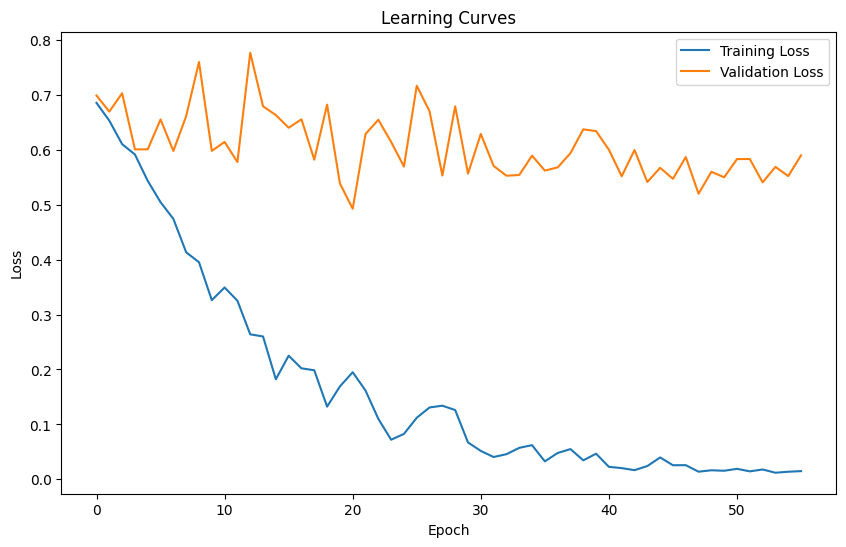

AUROC: 0.9227, Precision: 0.8824, Recall: 0.8219, F1 Score: 0.8511


C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Stopping early due to no improvement


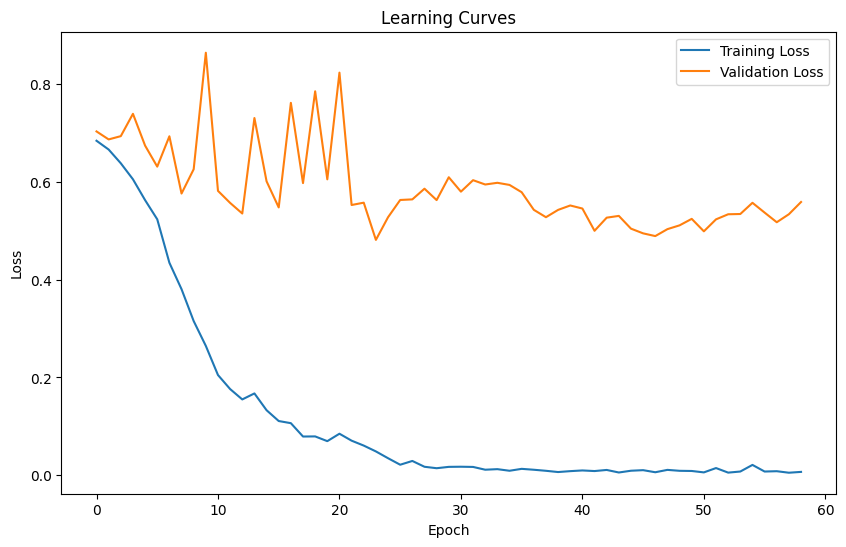

AUROC: 0.9071, Precision: 0.8125, Recall: 0.8904, F1 Score: 0.8497


C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


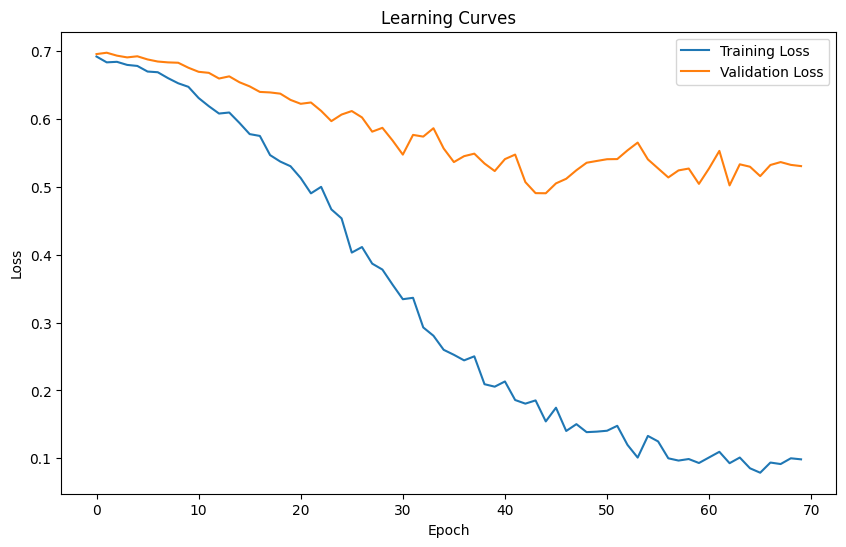

AUROC: 0.8779, Precision: 0.8209, Recall: 0.7534, F1 Score: 0.7857


C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


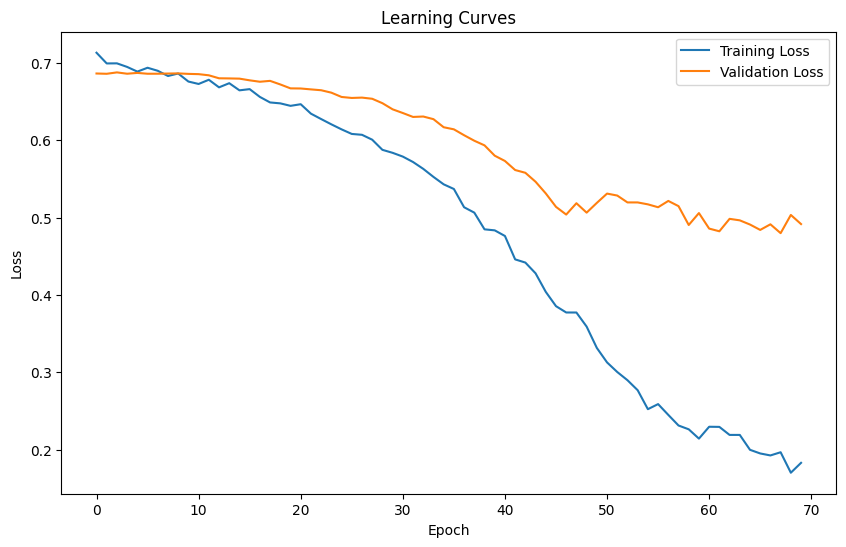

AUROC: 0.8570, Precision: 0.7595, Recall: 0.8219, F1 Score: 0.7895


In [9]:
# Model definition
class ModifiedResNet(nn.Module):
    def __init__(self, num_outputs=1):
        super(ModifiedResNet, self).__init__()
        # Load the pretrained ResNet model
        original_model = models.resnet101(pretrained=True)
        # Retain all layers except the final fully connected layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)
        # Ensure 'original_model.fc.in_features' is accessed correctly
        self.fc = nn.Linear(original_model.fc.in_features, num_outputs)

    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.features(x)
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        # Apply dropout
        x = self.dropout(x)
        # Output layer
        x = self.fc(x)
        return x

# Set device to CUDA (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization and system setup
def initialize_model(output_units, device):
    base_model = resnet101(weights=ResNet101_Weights.DEFAULT)
    model = ModifiedResNet(num_outputs=output_units)
    model.features = nn.Sequential(*list(base_model.children())[:-1])
    model.fc = nn.Linear(base_model.fc.in_features, output_units)
    return model.to(device)

def initialize_system(force_reinit=False):
    global model, optimizer, scheduler
    if 'model' not in globals() or force_reinit:
        model = initialize_model(1, device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=7)
    return model, optimizer, scheduler

model, optimizer, scheduler = initialize_system()

# Transformations to the image / augmentation techniques
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformations for validation/testing data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Applying different transformations to different datasets
train_dataset = TilesDataset(train_data, transform=train_transform)
val_dataset = TilesDataset(val_data, transform=test_transform)
test_dataset = TilesDataset(test_data, transform=test_transform)

# Initialize data loaders
train_loader, val_loader, test_loader = get_data_loaders(16)

def preprocess_and_show(path):
    original = Image.open(path)
    processed = transform(original)

    # Convert tensor back to image for displaying
    processed_image = transforms.ToPILImage()(processed).convert("RGB")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image)
    plt.title('Processed Image')
    plt.show()

# BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

# Training function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=70, patience=35, batch_size=batch_size, learning_rate=lr):
    writer = SummaryWriter(log_dir=log_dir)
    best_model_criteria = {'loss': float('inf'), 'auroc': 0}
    best_model_state = None
    train_losses = []
    val_losses = []
    val_aurocs = []
    patience_counter = 0  # Initialize patience counter

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

                probs = torch.sigmoid(outputs)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(probs.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_auroc = roc_auc_score(all_labels, all_predictions)
        val_aurocs.append(val_auroc)

        scheduler.step(avg_val_loss)
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        writer.add_scalar('AUROC/Validation', val_auroc, epoch)

        # Check if this is the best model
        if (avg_val_loss < best_model_criteria['loss']) or (avg_val_loss == best_model_criteria['loss'] and val_auroc > best_model_criteria['auroc']):
            best_model_criteria = {'loss': avg_val_loss, 'auroc': val_auroc}
            best_model_state = model.state_dict()
            patience_counter = 0  # reset patience since we found a better model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Stopping early due to no improvement")
                break

    # Plot the learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()
        
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_aurocs": val_aurocs
    }
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    writer.close()

    hyperparams = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'patience': patience
    }
    
    return model, history, hyperparams

# Evaluation function
def evaluate_model(model, dataloader, device):
    writer = SummaryWriter(log_dir=log_dir)
    model.eval()
    predictions = []
    true_labels = []
    prediction_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            # Assuming outputs are logits; apply sigmoid to get probabilities
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            prediction_probs.extend(probs)  # Save probabilities
            predictions.extend(preds)  # Save predictions
            true_labels.extend(labels.cpu().numpy())  # Save true labels

    # Compute metrics
    auroc = roc_auc_score(true_labels, prediction_probs)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, (np.array(prediction_probs) > 0.5).astype(int))
    
    # Save true_labels and prediction_probs for later plotting
    np.save('true_labels.npy', true_labels)
    np.save('prediction_probs.npy', prediction_probs)

    writer.close()

    print(f"AUROC: {auroc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return auroc, precision, recall, f1, cm


val_dataset = TilesDataset(val_data, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Use the evaluation function and print results appropriately
results = evaluate_model(model, val_loader, device)
auroc = results[0]  # AUROC is the first value in the tuple returned by evaluate_model
print(f"Validation AUROC: {auroc:.4f}")

# Hyperparameter tuning setup
# Define hyperparameters
hyperparams = {
    'learning_rate': [0.0001, 0.00001],
    'batch_size': [16, 64],
    'num_epochs': [70]
}

best_model = None
best_auroc = 0

# Hyperparameter tuning
for lr in hyperparams['learning_rate']:
    for batch_size in hyperparams['batch_size']:
        for num_epochs in hyperparams['num_epochs']:
            model = initialize_model(1, device)  # get a fresh model
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            trained_model, history, model_hyperparams = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=70, patience=35, batch_size=batch_size, learning_rate=lr)
            auroc, precision, recall, f1, cm = evaluate_model(trained_model, val_loader, device)
            print(f"AUROC: {auroc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
            print("Confusion Matrix:")
            print(cm)
            
            if auroc > best_auroc:
                best_auroc = auroc
                best_model = trained_model
                best_hyperparams = model_hyperparams  # keep track of the best model

# Save the best model
if best_model:
    # Correct path usage in torch.save
    torch.save(best_model.state_dict(), os.path.join(log_dir, "best_model.pth"))


In [10]:
def run_training_session():
    set_seed()  # Reset seed for reproducibility
    model, optimizer, scheduler = initialize_system(force_reinit=True) # Reinitialize to prevent overfitting from previous runs
    train_loader, val_loader, test_loader = get_data_loaders(16) # Ensure get_data_loaders matches 
    
    if best_model is not None:  # Import best model found during hyperparameter tuning
        model.load_state_dict(best_model.state_dict())
        print("Best Hyperparameters:")
        print(best_hyperparams)
    else:
        model, history, _ = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=100, patience=25, batch_size=16, learning_rate=0.001)
    
    return model  # Return the trained model

# Call run_training_session() to get the trained model
trained_model = run_training_session()


C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\pytorch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Hyperparameters:
{'batch_size': 16, 'learning_rate': 0.0001, 'num_epochs': 70, 'patience': 35}


In [11]:
# Evaluate the trained model on the test set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print("Evaluating the trained model:")
evaluate_model(trained_model, test_loader, device)

# Evaluate the best model (if available) on the test set
if best_model is not None:
    print("Evaluating the best model:")
    evaluate_model(best_model, test_loader, device)

test_auroc, test_precision, test_recall, test_f1, test_cm = evaluate_model(best_model, test_loader, device)
print("Test Confusion Matrix:")
print(test_cm)

Evaluating the trained model:
AUROC: 0.9383, Precision: 0.8780, Recall: 0.8727, F1 Score: 0.8754
Evaluating the best model:
AUROC: 0.9383, Precision: 0.8780, Recall: 0.8727, F1 Score: 0.8754


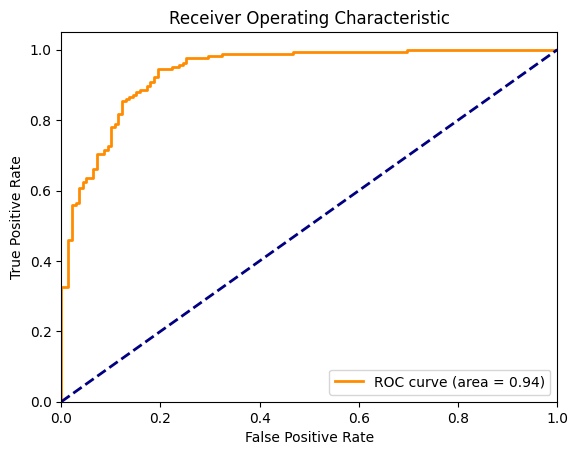

In [12]:
# Prepare Plotting
true_labels = np.load('true_labels.npy')
prediction_probs = np.load('prediction_probs.npy')

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Adjust the roc_curve function call
fpr, tpr, thresholds = roc_curve(true_labels, prediction_probs)  # Use predictions directly if they're 1D
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title1('Yap1 Overexpression in HNSC')
plt.title2('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'train_loader' is your DataLoader
images, labels = next(iter(train_loader))  # Get one batch of images and labels
image = images[0].numpy()  # Convert the first image of the batch to numpy array
image = np.transpose(image, (1, 2, 0))  # Change from (C, H, W) to (H, W, C) if necessary

# Normalize the image for display
image = (image - image.min()) / (image.max() - image.min())

# Example of adding a rectangle and text annotation
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')  # Display the image
rect = patches.Rectangle((50, 50), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.text(50, 45, 'Region of Interest', fontsize=12, color='red')
plt.show()

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

def visualize_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            features = model.features(inputs).view(inputs.size(0), -1)
            embeddings.append(features.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    reducer = umap.UMAP()
    embedding_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.colorbar(scatter)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Visualization')
    plt.show()

# Visualize embeddings using the test data loader
visualize_embeddings(model, test_loader, device)

In [ ]:
import cv2
import numpy as np

def grad_cam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    target_class = torch.tensor([target_class]).to(device)

    # Forward pass
    output = model(image)
    output_class = output.argmax(dim=1)

    # Backward pass
    model.zero_grad()
    output[:, target_class].backward()

    # Get gradients and activations
    gradients = model.gradients
    activations = model.activations

    # Pool gradients across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weigh activations by pooled gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average activations across channels
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Normalize heatmap
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[3]))

    # Overlay heatmap on image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image.detach().cpu().numpy().transpose(1, 2, 0), 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(10, 6))
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM for Class {target_class.item()} (Predicted: {output_class.item()})')
    plt.axis('off')
    plt.show()

# Example usage
image, target_class = next(iter(test_loader))
grad_cam(model, image[0], target_class[0].item())

In [ ]:
from sklearn.inspection import permutation_importance
import torch

def compute_permutation_importance(model, data_loader, device, criterion):
    model.eval()
    baseline_accuracies = []

    # Calculate baseline performance
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # Ensure binary classification threshold
            correct = (preds == labels).float().sum()
            baseline_accuracies.append(correct / len(labels))

    baseline_accuracy = torch.tensor(baseline_accuracies).mean().item()

    feature_importances = np.zeros(inputs[0].nelement())  # Total number of elements in the input

    # Calculate importance for each feature
    for i in range(inputs[0].nelement()):  # Iterate over all elements in the input tensor
        shuff_accuracies = []
        for _ in range(10):  # Number of shuffles
            shuffled_accuracies = []
            with torch.no_grad():
                for inputs, labels in data_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    shuff = inputs.clone()
                    # Shuffle one feature across all samples in the batch
                    shuff.view(shuff.size(0), -1)[:, i] = shuff.view(shuff.size(0), -1)[torch.randperm(shuff.size(0)), i]
                    outputs = model(shuff)
                    preds = torch.sigmoid(outputs) > 0.5
                    correct = (preds == labels).float().sum()
                    shuffled_accuracies.append(correct / len(labels))

            shuff_accuracies.append(torch.tensor(shuffled_accuracies).mean().item())

        # Average drop in accuracy when this feature is shuffled
        feature_importances[i] = baseline_accuracy - np.mean(shuff_accuracies)

    return feature_importances

# Compute feature importances
feature_importances = compute_permutation_importance(model, test_loader, device, criterion)

# Plotting the feature importances
import matplotlib.pyplot as plt

features = np.arange(len(feature_importances))
plt.figure(figsize=(12, 6))
plt.bar(features, feature_importances, color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance (Drop in Model Accuracy)')
plt.title('Feature Importance')
plt.show()
